# KonicaMinolta Waveform analysis HIB
## Configuration

1. Place Waveform files to analyze into [\\\p46.polytype.com\WpWiki-Media\internal\ipynb\Electronics\Wavefrom_KonicaMinolta\waveforms\](\\p46.polytype.com\WpWiki-Media\internal\ipynb\Electronics\Wavefrom_KonicaMinolta\waveforms\)
2. Change some constants to your likes
    
```
time_resolution = 0.1 # us for plotting
VH0 = 0  # V for PLSTM0 Voltage
VH1 = 8  # V for PLSTM1 Voltage
VH2 = 16 # V for PLSTM2 Voltage```
    
3. Write a new line with your file: `print_waveform('waveforms/waveform.wav')')`
4. Output will be displayed and also stored into [\\\p46.polytype.com\WpWiki-Media\internal\ipynb\Electronics\Wavefrom_KonicaMinolta\out\](\\p46.polytype.com\WpWiki-Media\internal\ipynb\Electronics\Wavefrom_KonicaMinolta\waveforms\)
    

## Usage

Example usage see below


In [11]:
# imports
import os
import binascii
import matplotlib.pyplot as plt
%matplotlib inline

# Configuration
# ============================================
#out_path = './out/'     # file output destination foder
#write_file = True       # write file block data to files

# dict value  [block length, invert]
word_size = 2  # nuber of bytes

block_header = [ "Active Sections"
                ,"Stream length"
                ,"Options"
                ,"Unused padding"
               ]
block_section = [ "Settings"
                 ,"TDROP"
                 ,"T0A"
                 ,"T0B"
                 ,"T1A"
                 ,"T1B"
                 ,"T2A"
                 ,"T2B"
                ]
block_footer = [ "Checksum W-1"
                ,"Checksum W"
               ]
time_resolution = 0.1 # us for plotting
VH0 = 0  # V for PLSTM0 Voltage
VH1 = 8  # V for PLSTM1 Voltage
VH2 = 16 # V for PLSTM2 Voltage

In [12]:
def print_word(idx, reg, val_h, val_i, file=None):
    """
    Print a word in different representations
    :return:
    """
    print("| [{0:>2}] | {1:15} | {2:7} | {3:6} |".format(idx, reg, val_h, val_i))


def write_line(data, filehandle):
    """
    Just another line writer, prints and write to file if given
    :param data:  string to print
    :param filehandle:  file handle
    :return:
    """
    print_data = ', '.join(data)
    print(print_data)
    if filehandle is not None and write_file:
        filehandle.write(print_data + '\n')

def readInChunks(fileObj, chunkSize=2):
    """
    Lazy function to read a file piece by piece.
    """
    ary = []
    while True:
        data = fileObj.read(chunkSize)
        if not data:
            break
        # yield data      # if we like to have a generator
        ary.append(data)  # if we liek to have an iterator (array)
    return ary

def bin_to_int(val):
    return int(binascii.hexlify(val), 16)


def bin_to_hexstr(val):
    return binascii.hexlify(val).decode("utf-8")

# Program Code
# ===================================================
# File Read & Analyze
def print_waveform(wave_file, verbose=True, print_plots=True):
  with open(wave_file, 'rb') as waveform:

      if verbose:
          print('print waveform file: {}'.format(wave_file))
          print('==============================================')

          print_word('ln', 'Name', 'hex', 'int')
          print('----------------------------------------------')

      # read file to array in chunks
      words = readInChunks(waveform, word_size)

      # read header
      line = 0
      for i in range(0, len(block_header)):
          idx = i + line
          val_hex = bin_to_hexstr(words[idx])
          val = bin_to_int(words[idx])
          if verbose:
              print_word(idx, block_header[i], '0x'+str(val_hex), str(val))
      line += len(block_header)

      # read sections
      nbr_of_sections = bin_to_int(words[0])
      data = []
      for sect in range(nbr_of_sections):
          data.append([])
          for i in range(0, len(block_section)):
              idx = i + line
              val_hex = bin_to_hexstr(words[idx])
              val = bin_to_int(words[idx])
              if i > 0:
                  data[sect].append(int((float(val)/100.0)/time_resolution))
              else:
                  data[sect].append(val_hex)
              if verbose:
                  print_word(idx, block_section[i], '0x'+str(val_hex), str(val))
          line += len(block_section)

      # read footer
      for i in range(0, len(block_footer)):
          idx = i + line
          val_hex = bin_to_hexstr(words[idx])
          val = bin_to_int(words[idx])
          if verbose:
              print_word(idx, block_footer[i], '0x'+str(val_hex), str(val))
      line += len(block_footer)

      # prepare data for plotting
      #nbr_of_sections
      #time_resolution
      tdrop_idx = 1
      t0a_idx = 2
      t0b_idx = 3
      t1a_idx = 4
      t1b_idx = 5
      t2a_idx = 6
      t2b_idx = 7
      
      plstm =  [[],[],[]]
      for sect in range(nbr_of_sections):
          for tdrop in range(data[sect][tdrop_idx]): # section size
            if tdrop < data[sect][t0a_idx] or tdrop > data[sect][t0b_idx]:
                plstm[0].append(0)
            else:
                plstm[0].append(VH0)
            if tdrop < data[sect][t1a_idx] or tdrop > data[sect][t1b_idx]:
                plstm[1].append(0)
            else:
                plstm[1].append(VH1)
            if tdrop < data[sect][t2a_idx] or tdrop > data[sect][t2b_idx]:
                plstm[2].append(0)
            else:
                plstm[2].append(VH2)
      wave_data = []
      time_data = []
      time = 0.0
      for t in range(len(plstm[0])):
          wave_data.append(plstm[2][t]-plstm[1][t])
          time_data.append(time)
          time += time_resolution
      
      # plotting data
      if print_plots:
          plt.figure(figsize=(30,40))
          fig, axes = plt.subplots(4)
          fig.set_figheight(15)
          fig.set_figwidth(15)
          plt.suptitle(os.path.basename(wave_file),y=1.01)
          
          for i in range(4):
              plt.tight_layout()
              if i == 0:
                p = axes[0]
                p.plot(time_data, wave_data, 'b-')
                p.set_title("Waveform PLSTM 1 & 2".format(i))
                p.set_ylim([min(wave_data)-1,max(wave_data)+1])
              elif i == 1:
                p = axes[1]
                p.plot(time_data, plstm[0], 'b-')
                p.set_title("Waveform PLSTM 0".format(i))
                p.set_ylim([0,max(plstm[0])+1])
              elif i == 2:
                p = axes[2]
                p.plot(time_data, plstm[1], 'b-')
                p.set_title("Waveform PLSTM 1".format(i))
                p.set_ylim([0,max(plstm[1])+1])
              elif i == 3:
                p = axes[3]
                p.plot(time_data, plstm[2], 'b-')
                p.set_title("Waveform PLSTM 2".format(i))
                p.set_ylim([0,max(plstm[2])+1])
                            
              
              p.set_xlabel('Time in 0.1 [us]')
              p.set_ylabel('Voltage [V]')
          plt.show()
          fig.savefig("./out/{}.png".format(os.path.splitext(os.path.basename(wave_file))[0], dpi = 600))


print waveform file: waveforms/default_waveform.wav
| [ln] | Name            | hex     | int    |
----------------------------------------------
| [ 0] | Active Sections | 0x0003  | 3      |
| [ 1] | Stream length   | 0x001e  | 30     |
| [ 2] | Options         | 0x0000  | 0      |
| [ 3] | Unused padding  | 0x0000  | 0      |
| [ 4] | Settings        | 0x001f  | 31     |
| [ 5] | TDROP           | 0x2710  | 10000  |
| [ 6] | T0A             | 0x01f4  | 500    |
| [ 7] | T0B             | 0x03e8  | 1000   |
| [ 8] | T1A             | 0x07d0  | 2000   |
| [ 9] | T1B             | 0x1388  | 5000   |
| [10] | T2A             | 0x0bb8  | 3000   |
| [11] | T2B             | 0x1770  | 6000   |
| [12] | Settings        | 0x001f  | 31     |
| [13] | TDROP           | 0x4e20  | 20000  |
| [14] | T0A             | 0x01f4  | 500    |
| [15] | T0B             | 0x03e8  | 1000   |
| [16] | T1A             | 0x07d0  | 2000   |
| [17] | T1B             | 0x1388  | 5000   |
| [18] | T2A             | 

<Figure size 2160x2880 with 0 Axes>

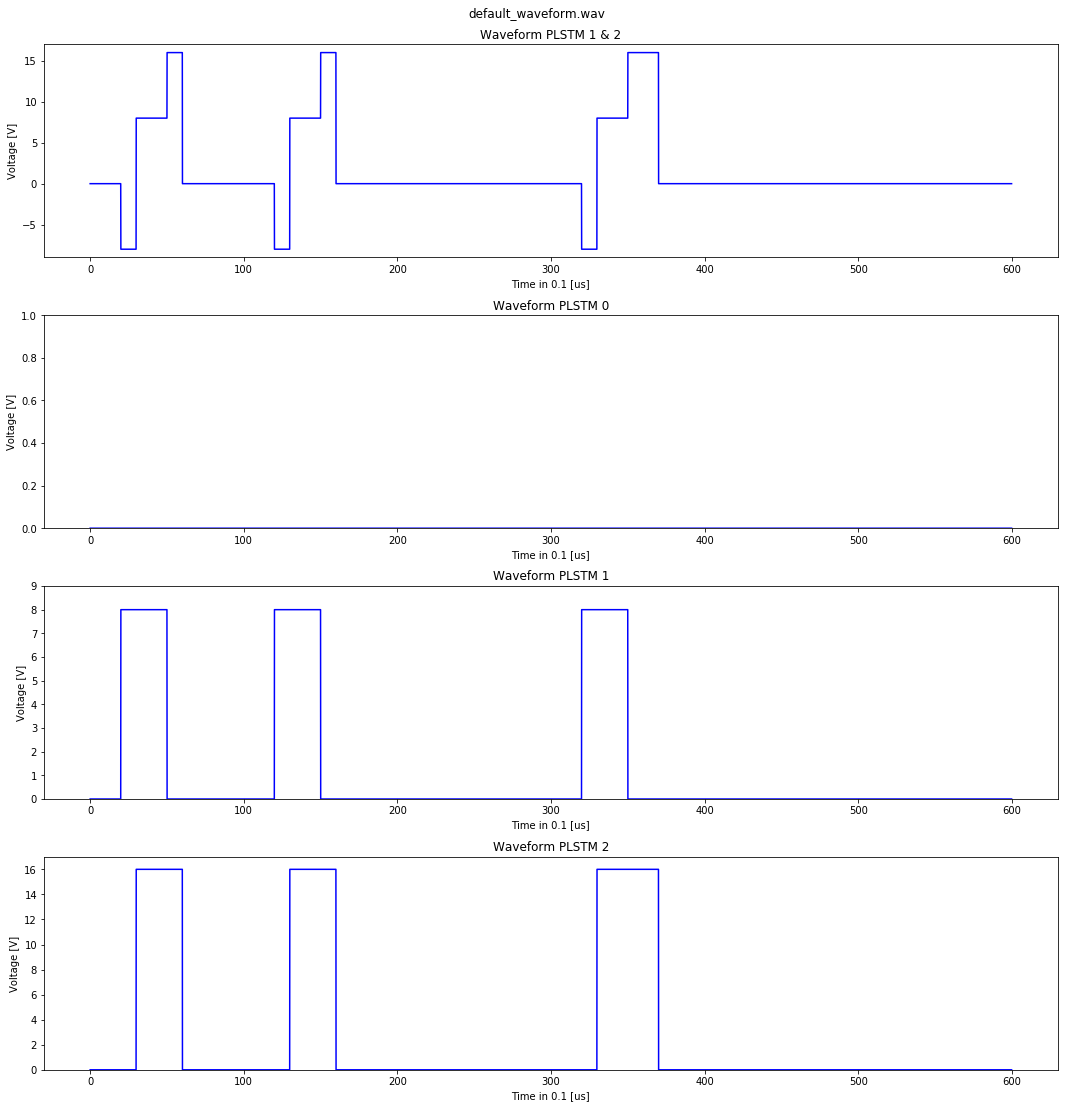

print waveform file: waveforms/waveform.wav
| [ln] | Name            | hex     | int    |
----------------------------------------------
| [ 0] | Active Sections | 0x0003  | 3      |
| [ 1] | Stream length   | 0x001e  | 30     |
| [ 2] | Options         | 0x0000  | 0      |
| [ 3] | Unused padding  | 0x0000  | 0      |
| [ 4] | Settings        | 0x001f  | 31     |
| [ 5] | TDROP           | 0x0af0  | 2800   |
| [ 6] | T0A             | 0x0000  | 0      |
| [ 7] | T0B             | 0x0000  | 0      |
| [ 8] | T1A             | 0x0235  | 565    |
| [ 9] | T1B             | 0x0695  | 1685   |
| [10] | T2A             | 0x0000  | 0      |
| [11] | T2B             | 0x0230  | 560    |
| [12] | Settings        | 0x001f  | 31     |
| [13] | TDROP           | 0x0af0  | 2800   |
| [14] | T0A             | 0x0000  | 0      |
| [15] | T0B             | 0x0000  | 0      |
| [16] | T1A             | 0x0235  | 565    |
| [17] | T1B             | 0x0695  | 1685   |
| [18] | T2A             | 0x0000  

<Figure size 2160x2880 with 0 Axes>

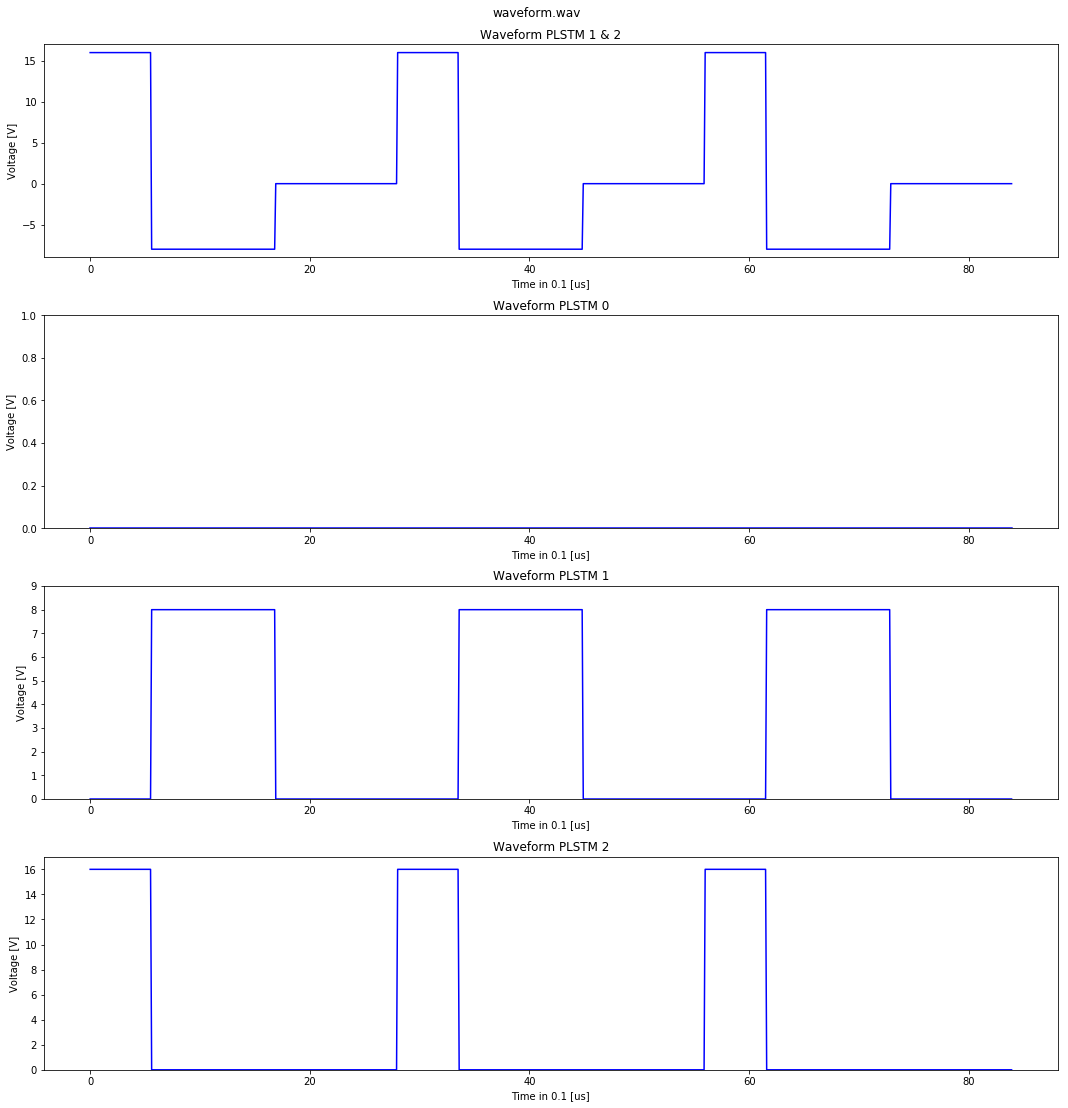

print waveform file: waveforms/waveform_MH.wav
| [ln] | Name            | hex     | int    |
----------------------------------------------
| [ 0] | Active Sections | 0x0003  | 3      |
| [ 1] | Stream length   | 0x001e  | 30     |
| [ 2] | Options         | 0x0000  | 0      |
| [ 3] | Unused padding  | 0x0000  | 0      |
| [ 4] | Settings        | 0x001f  | 31     |
| [ 5] | TDROP           | 0x0af0  | 2800   |
| [ 6] | T0A             | 0x0000  | 0      |
| [ 7] | T0B             | 0x0000  | 0      |
| [ 8] | T1A             | 0x0235  | 565    |
| [ 9] | T1B             | 0x0695  | 1685   |
| [10] | T2A             | 0x0000  | 0      |
| [11] | T2B             | 0x0235  | 565    |
| [12] | Settings        | 0x001f  | 31     |
| [13] | TDROP           | 0x0af0  | 2800   |
| [14] | T0A             | 0x0000  | 0      |
| [15] | T0B             | 0x0000  | 0      |
| [16] | T1A             | 0x0235  | 565    |
| [17] | T1B             | 0x0695  | 1685   |
| [18] | T2A             | 0x000

<Figure size 2160x2880 with 0 Axes>

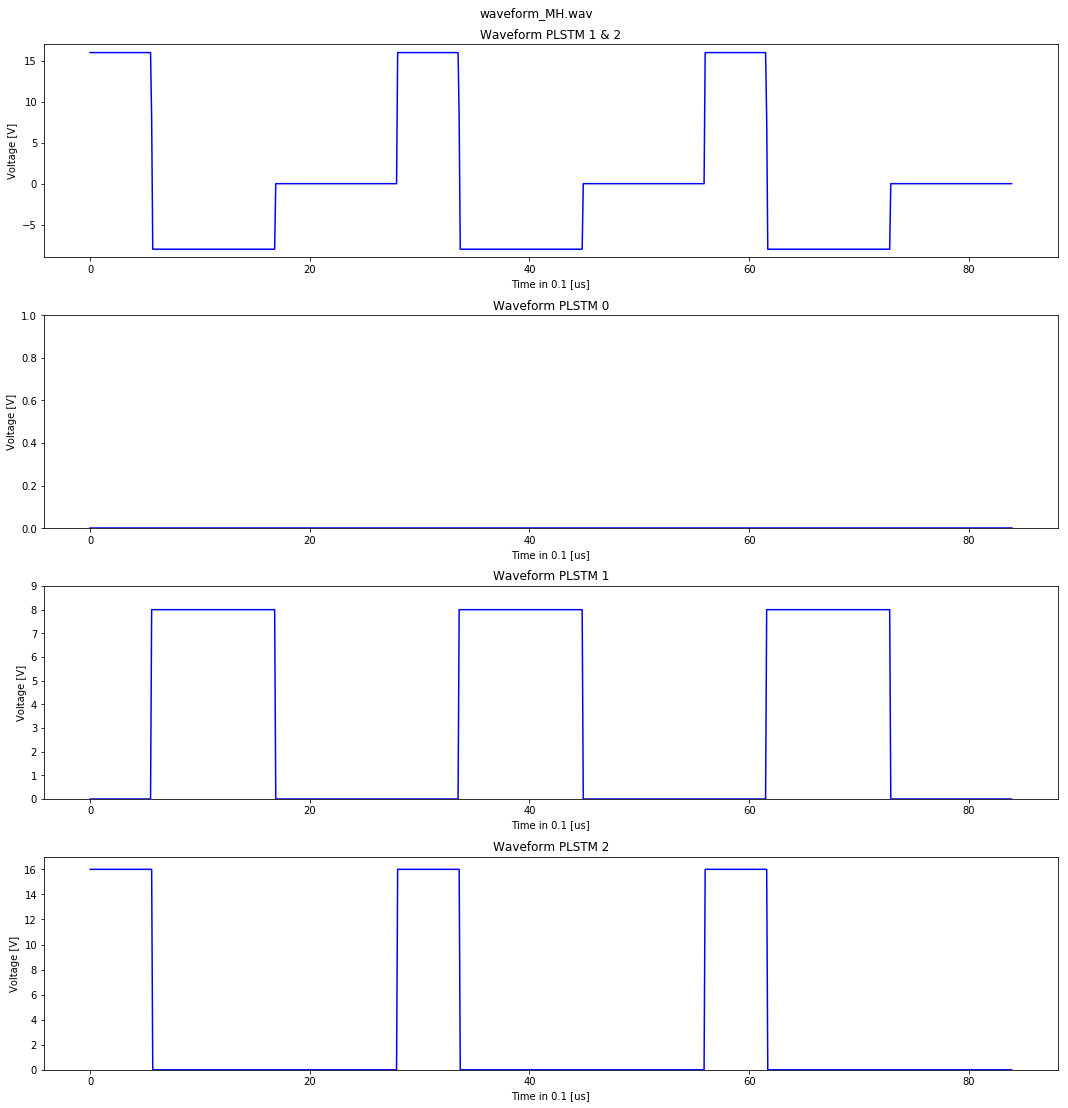

print waveform file: waveforms/waveform_LH.wav
| [ln] | Name            | hex     | int    |
----------------------------------------------
| [ 0] | Active Sections | 0x0003  | 3      |
| [ 1] | Stream length   | 0x001e  | 30     |
| [ 2] | Options         | 0x0000  | 0      |
| [ 3] | Unused padding  | 0x0000  | 0      |
| [ 4] | Settings        | 0x001f  | 31     |
| [ 5] | TDROP           | 0x0e42  | 3650   |
| [ 6] | T0A             | 0x0000  | 0      |
| [ 7] | T0B             | 0x0000  | 0      |
| [ 8] | T1A             | 0x02da  | 730    |
| [ 9] | T1B             | 0x088e  | 2190   |
| [10] | T2A             | 0x0000  | 0      |
| [11] | T2B             | 0x02da  | 730    |
| [12] | Settings        | 0x001f  | 31     |
| [13] | TDROP           | 0x0e42  | 3650   |
| [14] | T0A             | 0x0000  | 0      |
| [15] | T0B             | 0x0000  | 0      |
| [16] | T1A             | 0x02da  | 730    |
| [17] | T1B             | 0x088e  | 2190   |
| [18] | T2A             | 0x000

<Figure size 2160x2880 with 0 Axes>

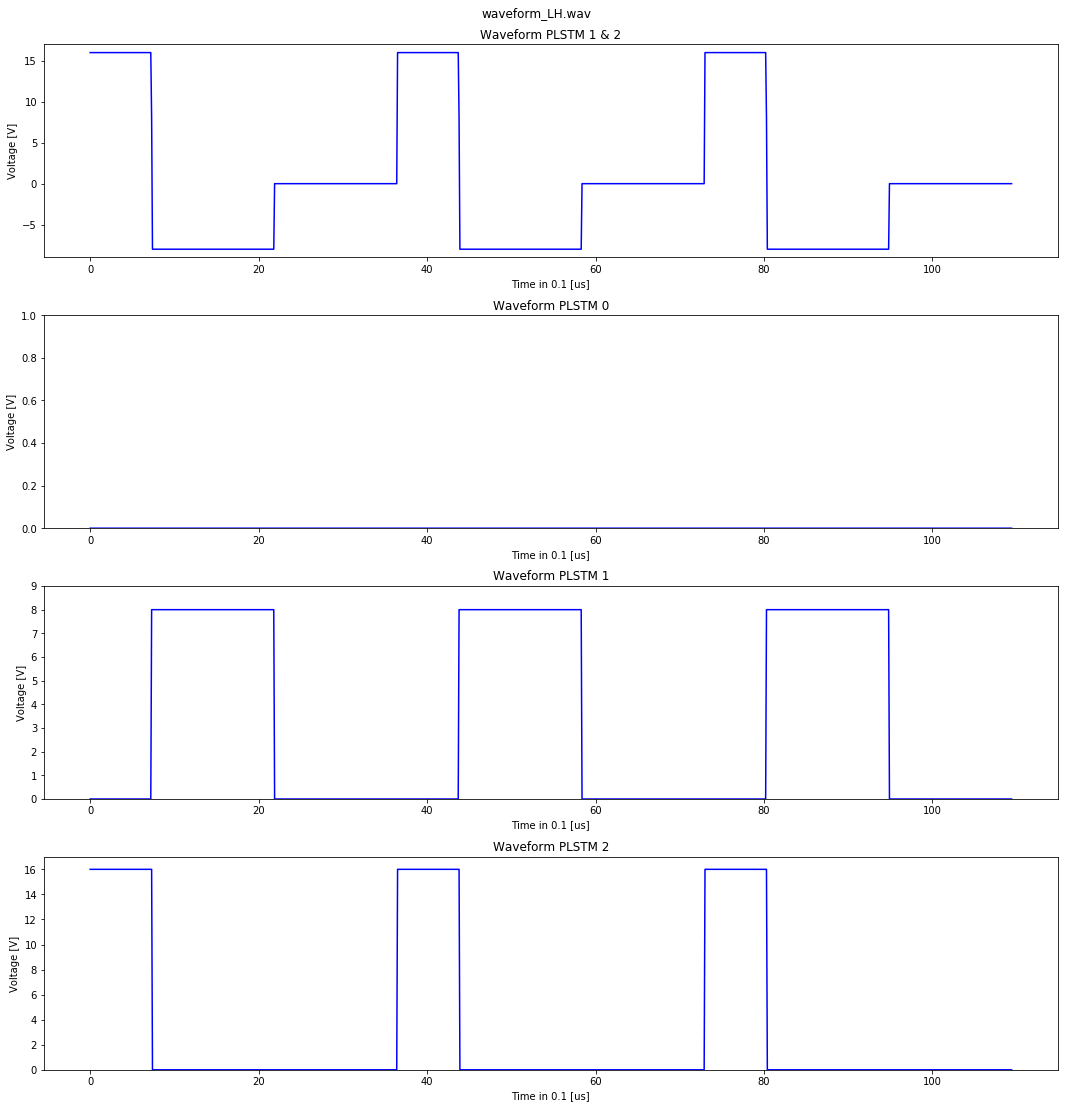

In [15]:
print_waveform('waveforms/default_waveform.wav')
print_waveform('waveforms/waveform.wav')
print_waveform('waveforms/waveform_MH.wav')
print_waveform('waveforms/waveform_LH.wav')
